In [136]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sin,cos,tan
import math
from __future__ import division

In [137]:
#file names of dataset
    
#461 reflectance per sample and total 19 samples 
Data = np.zeros([461,19])    

#data files --> 9 mare + 10 highland
files = pd.read_csv('Dataset/abundance_data.csv',usecols=[0],header=None)
files = files.values


'''
sample order:

10084Kdata.txt
12001Kdata.txt
12030Kdata.txt
15041Kdata.txt
15071Kdata.txt
70181Kdata.txt
71061Kdata.txt
71501Kdata.txt
79221Kdata.txt
14141Kdata.txt
14163Kdata.txt
14259Kdata.txt
14260Kdata.txt
61141Kdata.txt
61221Kdata.txt
62231Kdata.txt
64801Kdata.txt
67461Kdata.txt
67481Kdata.txt


'''

for i in range(19):
    
    temp = files[i][0]    
    file_name = 'Dataset/combine-data/'+str(temp)+'Kdata.txt'
    #print(str(temp)+'Kdata.txt')
    
    data_df = pd.read_csv(file_name, delimiter = '\t', header=None,usecols = [0,1,3,5,7])

    #convert panda to numpy array
    data = data_df.values

    #lamda values
    lamda_values = data[:,0]

    #Reflectance values
    Reflectance_values = data[:,2]
    
    Data[:,i] = Reflectance_values
    
    #plot reflectance values
    #plt.plot(lamda_values,Reflectance_values)


In [138]:
#order of mineral: [Agglutinate, pyroxene, Plagioclase, Olivine, Ilmenite, Volcanic Glass]

#density in g/cc
density = np.array([1.8, 3.3, 2.69, 3.3, 4.79, 2.4])

#abundance for sample 14141(here, abundance of metallic iron not present, order different and both pyroxenes mixed)
abundance = np.zeros([19,6])

#read abundance data from file
datafile = pd.read_csv('Dataset/abundance_data.csv',usecols=[1,2,3,4,5,6],header=None)
abundance = datafile.values

'''
our abundance data for 6 minerals for 19 samples

[1,2,3,4,5,6] --> [Agglutinate, pyroxene, Plagioclase, Olivine, Ilmenite, Volcanic Glass]

       1     2     3    4    5     6
0   57.0  12.2  17.1  1.1  5.2   2.9
1   56.8  17.9  13.9  4.2  1.8   1.3
2   49.8  20.0  29.0  3.7  3.2   1.5
3   56.7  17.0  16.2  2.4  0.8   2.6
4   49.2  16.7  19.4  2.8  1.8   4.1
5   51.7   8.5  18.3  3.8  6.7   9.2
6   37.9  12.5  15.2  4.5  9.7  18.8
7   44.8  13.7  19.8  3.4  9.7   7.5
8   54.3   9.7  16.0  3.4  6.0   9.2
9   48.6  10.9  28.0  1.6  1.1   7.4
10  58.5  13.8  18.3  2.1  0.9   4.1
11  68.7   9.1  15.4  1.4  1.2   2.7
12  65.2  12.1  16.1  1.5  1.0   2.6
13  53.9   3.3  40.3  1.6  0.3   0.4
14  32.6   5.3  59.4  2.0  0.3   0.2
15  55.0   4.4  37.8  1.7  0.5   0.4
16  61.0   2.8  34.5  1.0  0.2   0.3
17  32.4   4.1  61.0  1.5  0.3   0.2
18  28.6   5.6  62.0  2.9  0.2   0.4

'''

#diameter has different samples for orthopyroxene. Only one needed
meanDiameter = np.array([110, 175, 11, 20, 15, 10])

#refractive index for metallic iron taken as avg of 2.25,3.36
refractiveIndex = [1.49, 1.75, 1.56, 1.83, 2.13, 1.64]

#imaginary refractive index (k)
#refractiveIndexI = [.2, .2, .2, .2, .2, .2]*5

In [139]:
#incidence angle
i = math.pi/6
#emergence angle
e = 0
#phase angle
g = math.pi/6

mu = cos(e)
mu_0 = cos(i)

In [140]:
def get_B(h,g):
    
    B = 1/(1 + (1/h)*tan(g/2))
    return B

def get_P(g,b,c):
    
    P = 1 + b*cos(g) + c*(1.5*cos(g)*cos(g) - .5)
    return P


In [141]:
def get_H(x,y):
    
    g = np.sqrt(1-y)
    r = (1-g)/(1+g)
    value = 1.0/(1-(1-g)*x*(r + (1-.5*r-r*x)*np.log((1+x)/x)))
    return value

In [142]:
def W_ave(index,w):
    
    #index : sample index (0-15)
    
    nume = np.zeros([6])
    deno = np.zeros([6])
    for i in range(0,6):
        nume[i] = abundance[index,i]*w[i]/(density[i]*meanDiameter[i])
        deno[i] = abundance[index,i]/(density[i]*meanDiameter[i])

    w_ave = np.sum(nume)/np.sum(deno)
    return w_ave

In [143]:
def Reflectance(lamda_index,m_index,w,h,b,c):
    
    #lamda_index : index of wavelength (0-461)
    #m_index : sample index (0-15)
    
    w_ave = W_ave(m_index,w)
    t1 = 1 + get_B(h,g)
    t2 = get_P(g,b,c)
    t3 = get_H(mu_0,w_ave)*get_H(mu,w_ave)
    t5 = w_ave/(4*math.pi)
    t6 = mu_0/(mu_0 + mu)
    
    #print(t1)
    ref = t5*t6*(t1*t2+t3-1)
    return ref

In [144]:
def Error(r1,r2):
    
    #r1 : relfectance measured 
    #r2 : reflectance ground truth
    
    # return mean square error  
    
    err = np.sum(np.dot(r1-r2,r1-r2))/(2*len(r1))
    
    return err

In [145]:
#yet to implement
def calc_dHdwa(mu,w_ave):
    
    h = .01
    w_ave1 = w_ave+h
    w_ave2 = w_ave-h
    
    f1 = (get_H(mu,w_ave1) - get_H(mu,w_ave))/h
    f2 = (get_H(mu,w_ave1) - get_H(mu,w_ave2))/2*h
    
    return f1

In [146]:
def calc_dRdwa(lamda_index,m_index,w,h,b,c):
    
    #lamda_index : index of wavelength (0-461)
    #m_index : sample index (0-15)
        
    w_ave = W_ave(m_index,w)
    t1 = (mu_0/(4*math.pi*(mu_0 + mu))*(1+get_B(h,g))*get_P(g,b,c))
    t = calc_dHdwa(mu_0,w_ave)*get_H(mu,w_ave) + calc_dHdwa(mu,w_ave)*get_H(mu_0,w_ave)
    t2 = w_ave*t
            
    return t1 + t2 - 1

In [147]:
def calc_dwadw(lamda_index,m_index,w_index,w,h,b,c):
    
    # lamda_index : index of wavelength (0-461)
    # m_index : sample index (0-15)
    # w_index : mineral index (0-6)
    
    nume = abundance[m_index,w_index]/(density[w_index]*meanDiameter[w_index])
    deno = np.sum(abundance[m_index,:]/(density[:]*meanDiameter[:]))
    
    return nume/deno

In [148]:
def calc_dRdw(lamda_index,m_index,w_index,w,h,b,c):
    
    #lamda_index : index of wavelength (0-461)
    #m_index : sample index (0-15)
    
    
    dRdwa = calc_dRdwa(lamda_index,m_index,w,h,b,c)   # dR/dwave
    dwadw = calc_dwadw(lamda_index,m_index,w_index,w,h,b,c)   # dwave/dw

    dRdw = dRdwa * dwadw
    
    
    return 1

In [149]:
def calc_dRdB(lamda_index,m_index,w,h,b,c):
    
    ##lamda_index : index of wavelength (0-461)
    #m_index : sample index (0-15)
    
    w_ave = W_ave(m_index,w)
    P = get_P(g,b,c)
    
    dRdB = w_ave*mu_0*P/(4*math.pi*(mu_0+mu))
    
    return dRdB

In [150]:
def calc_dBdh(lamda_index,m_index,w,h,b,c):
    
    ##lamda_index : index of wavelength (0-461)
    #m_index : sample index (0-15)
    
    dBdh = -tan(g/2)/((h+tan(g/2)**2))
    return dBdh

In [151]:
#yet to implement 
def calc_dRdh(lamda_index,m_index,w,h,b,c):
    
    ##lamda_index : index of wavelength (0-461)
    #m_index : sample index (0-15)
    
    dRdB = calc_dRdB(lamda_index,m_index,w,h,b,c)
    dBdh = calc_dBdh(lamda_index,m_index,w,h,b,c)
    
    dRdh = dRdB*dBdh
    
    return dRdh

In [152]:
def calc_dRdb(lamda_index,m_index,w,h,b,c):
    
    ##lamda_index : index of wavelength (0-461)
    #m_index : sample index (0-15)
    
    wavg = W_ave(m_index,w)
    B = get_B(g,h)
    
    k1 = (wavg/4*math.pi)*(mu_0/(mu_0+mu))
    k4 = 1 + B
    
    grad = k1*k4*cos(g)
    
    return grad

In [153]:
def calc_dRdc(lamda_index,m_index,w,h,b,c):
    
    ##lamda_index : index of wavelength (0-461)
    #m_index : sample index (0-15)
    
    wavg = W_ave(m_index,w)
    B = get_B(g,h)
    
    k1 = (wavg/4*math.pi)*(mu_0/(mu_0+mu))
    k4 = 1 + B
    
    grad = k1*k4*(1.5*(cos(g)**2) - 0.5)
    
    return grad

In [154]:
def Gradient(lamda_index,reflectance,reflectance_true,w,h,b,c):
    dw = np.zeros([6])
    dh = 0
    db = 0
    dc = 0
    
    erL1 = reflectance - reflectance_true
    
    # calculate dw
    for j in range(6):
        dRdw = np.zeros([15])
        temp = np.zeros([15])
        for i in range(15):
            dRdw[i] = calc_dRdw(lamda_index,i,j,w,h,b,c)
            temp = erL1[i]*dRdw[i]
        dw[j] = np.sum(temp)/15
    
    # calculate dh
    dRdh = np.zeros([15])
    temp = np.zeros([15])
    for i in range(15):
        dRdh[i] = calc_dRdh(lamda_index,i,w,h,b,c)
        temp[i] = erL1[i]*dRdh[i]
    dh = np.sum(temp)/15
    
    # calculate db
    dRdb = np.zeros([15])
    temp = np.zeros([15])
    for i in range(15):
        dRdb[i] = calc_dRdb(lamda_index,i,w,h,b,c)
        temp[i] = erL1[i]*dRdb[i]
    db = np.sum(temp)/15
    
    # calculate dc
    dRdc = np.zeros([15])
    temp = np.zeros([15])
    for i in range(15):
        dRdc[i] = calc_dRdc(lamda_index,i,w,h,b,c)
        temp[i] = erL1[i]*dRdc[i]
    dc = np.sum(temp)/15
     
    return dw,dh,db,dc 

In [155]:
def update(w,h,b,c,lr,dw,dh,db,dc):
    
    for i in range(6):
            w[i] = w[i] - lr*dw[i]
    
    h = h - lr*dh
    b = b - lr*db
    c = c - lr*dc
    
    return w,h,b,c

In [189]:
def optimize(lamda_index):
    
    # random initial values for all parameters
    
    w = np.random.random(6)
    h = np.random.random()
    b = np.random.random()
    c = np.random.random()
    
    #learning rate
    lr = .005
    
    #number of epochs
    epochs = 3000
    
    reflectance = np.zeros(15)
    
    for i in range(15):
            reflectance[i] = Reflectance(lamda_index,i,w,h,b,c)

    reflectance_true = Data[lamda_index,0:15]

    error = Error(reflectance,reflectance_true)
    
    print('error: %f'%error)
    
    
    for itr in range(epochs):
        for i in range(15):
            reflectance[i] = Reflectance(lamda_index,i,w,h,b,c)

        reflectance_true = Data[lamda_index,0:15]

        error = Error(reflectance,reflectance_true)

        dw,dh,db,dc = Gradient(lamda_index,reflectance,reflectance_true,w,h,b,c)

        w,h,b,c = update(w,h,b,c,lr,dw,dh,db,dc)
        
        if itr%100 == 0:
            print('epoch: %d, error = %f'%(itr,error))

    return w,h,b,c

In [197]:
# w for 6 minerals for 461 wavelengths(lambdas)
w = np.zeros([461,6])

# h,b and c values for 461 wavelengths
h = np.zeros(461)
b = np.zeros(461)
c = np.zeros(461)


for lamda_index in range(1):
    
    # lambda value
    lamda = lamda_values[lamda_index]
    
    # optimize w,h,b and c for particular lamda
    temp_w,temp_h,temp_b,temp_c = optimize(lamda_index)
    
    print(lamda_index)
    
    w[lamda_index,:] = temp_w
    h[lamda_index] = temp_h
    b[lamda_index] = temp_b
    c[lamda_index] = temp_c
    
    print(w[0,:])
    
    
        

error: 0.001541
epoch: 0, error = 0.001541
epoch: 100, error = 0.001544
epoch: 200, error = 0.001548
epoch: 300, error = 0.001552
epoch: 400, error = 0.001558
epoch: 500, error = 0.001565
epoch: 600, error = 0.001572
epoch: 700, error = 0.001581
epoch: 800, error = 0.001590
epoch: 900, error = 0.001601
epoch: 1000, error = 0.001612
epoch: 1100, error = 0.001624
epoch: 1200, error = 0.001637
epoch: 1300, error = 0.001651
epoch: 1400, error = 0.001666
epoch: 1500, error = 0.001682
epoch: 1600, error = 0.001698
epoch: 1700, error = 0.001716
epoch: 1800, error = 0.001734
epoch: 1900, error = 0.001753
epoch: 2000, error = 0.001773
epoch: 2100, error = 0.001794
epoch: 2200, error = 0.001816
epoch: 2300, error = 0.001838
epoch: 2400, error = 0.001862
epoch: 2500, error = 0.001886
epoch: 2600, error = 0.001911
epoch: 2700, error = 0.001937
epoch: 2800, error = 0.001963
epoch: 2900, error = 0.001991
0
[0.77613234 1.11568039 0.25489168 1.16665712 1.13033224 1.08756645]


[0. 0. 0. 0. 0. 0.]
0.0
[0.99303671 0.31873082 0.28977843 0.44285784 0.2513613  0.54633204]
0.5841820113714633
0.4711392384571923
0.3040837696440172
0.001189175798364416


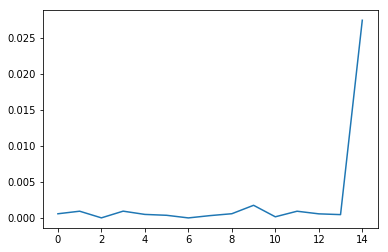

In [195]:
print(w[0,:])
print(h[0])
print(temp_w)
print(temp_h)
print(temp_c)
print(temp_b)
lamda_index = 0
reflectance = np.zeros(15)
for i in range(15):
            reflectance[i] = Reflectance(lamda_index,i,temp_w,temp_h,temp_b,temp_c)

reflectance_true = Data[lamda_index,0:15]

error = Error(reflectance,reflectance_true)
print(error)

plt.plot((reflectance-reflectance_true)**2)

In [ ]:
for i in range(10):
    print(i)

In [ ]:
a

In [ ]:
math.pi

In [ ]:
w_ave,step = np.linspace(0.0,1.0,num=100,retstep=True)
H = np.zeros(len(w_ave))
slop_H = np.zeros(len(w_ave)-1)
for i in range(len(w_ave)):
    H[i] = get_H(mu,w_ave[i])
    if i>0:
        slop_H[i-1] = (H[i] - H[i-1])/step
plt.plot(w_ave,H)
plt.figure()
plt.plot(slop_H)

In [ ]:
get_B(.5,.5)*get_P(.5,.5,.5)

In [ ]:
abundance[0,:]/(density[:]*meanDiameter[:])